In [37]:
from selenium import webdriver
from bs4 import BeautifulSoup
import urllib.request
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait

import datetime
import time
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime

import re
import matplotlib.pyplot as plt
import seaborn as sns

# record when the data is crawled
date_today = date.today()

In [ ]:
# initial url
## one-way from NYC to LA on Dec 23rd
url = "https://www.expedia.com/Flights-Search?flight-type=on&mode=search&trip=oneway&leg1=from%3ANew+York+%28NYC+-+All+Airports%29%2Cto%3ALos+Angeles+%28LAX+-+Los+Angeles+Intl.%29%2Cdeparture%3A12%2F23%2F2022TANYT&options=cabinclass%3Aeconomy&passengers=children%3A0%2Cadults%3A1%2Cseniors%3A0%2Cinfantinlap%3AY&fromDate=12%2F23%2F2022&d1=2022-12-23"

In [ ]:
# initialize driver
driver = webdriver.Chrome(executable_path='/Users/19493/Downloads/chromedriver_win32/chromedriver.exe')

C:\Users\19493\AppData\Local\Temp/ipykernel_17748/3658957831.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path='/Users/19493/Downloads/chromedriver_win32/chromedriver.exe')


In [ ]:
# click on "Load More"
#loadmore_path = '//*[@id="app-layer-base"]/div[3]/div[3]/div/section/main/div[4]/section/button'
#driver.find_element(By.XPATH,loadmore_path).click()

In [ ]:
# initialize an empty dataframe for storing crawled data 
# We create a df at global environment, so we can keep append data into this df every hour 
df = pd.DataFrame(columns = ['dep_times', 'arr_times', 'airlines',
                             'durations', 'stops', 'prices'])

In [ ]:
for i in range(8):
    
    # Open the designated url 
    driver.get(url)
    time.sleep(5)
    
    
    # Wait the button to be clickable , and click the "Show More" button
    WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, "//button[@aria-label='Show More']"))).click()
    # Wait 30 secs till all results are fully loaded 
    time.sleep(30) 
    
    # Get departure times
    dep_times = driver.find_elements('xpath',"//span[@data-test-id='departure-time']")
    dep_times_list = [value.text.split(' ')[0] for value in dep_times]
    
    #Get arrival times
    arr_times = driver.find_elements('xpath',"//span[@data-test-id='departure-time']")
    arr_times_list = [value.text.split(' ')[2] for value in dep_times]
    
    #Get airline name
    airlines = driver.find_elements('xpath', "//div[@data-test-id='flight-operated']")
    airlines_list = [value.text for value in airlines]
    
    # Get durations
    durations = driver.find_elements('xpath',"//div[@data-test-id='journey-duration']")
    durations_list = [value.text.split(' ')[0:2] for value in durations]
    
    # Get stops
    stops= driver.find_elements('xpath',"//div[@data-test-id='journey-duration']")
    stops_list = [value.text.split(' ')[2].split('(')[1].split(')')[0] for value in stops]
    
    # Get prices 
    prices = driver.find_elements('xpath',"//div[@data-test-id='price-column']")
    price_list = [value.text.split('$')[1].split('\n')[0] for value in prices]
    
    # Temperary dataframe to store craweled data
    temp_df = pd.DataFrame(list(zip(dep_times_list, arr_times_list, airlines_list, durations_list, stops_list, price_list)),
                  columns = ['dep_times', 'arr_times', 'airlines',
                             'durations', 'stops', 'prices'])
    
    
    # Append data into our df 
    df = df.append(temp_df,ignore_index=True)
    
    if i == 7: 
        # store craweled data into a csv file at the 8th hour interval
        df.to_csv('expedia.csv',encoding='utf-8', index=False)
    else:
    # pause for an hour and re-crawel the data 
        time.sleep(3600)

In [38]:
# Import craweled data 
df = pd.read_csv("expedia.csv")

In [39]:
# Check the crawled data
print(df)
# Check the datatype for each column
df.dtypes

    dep_times arr_times                                           airlines  \
0     12:15pm    5:40pm                                  American Airlines   
1      9:30pm    3:51pm                                    Spirit Airlines   
2      6:00am    9:07am                                    JetBlue Airways   
3      6:59am   10:17am                                    JetBlue Airways   
4      4:55pm    8:12pm                                    Spirit Airlines   
..        ...       ...                                                ...   
787    8:45am   12:05pm  American Airlines • American Airlines 9457 ope...   
788    6:45pm   11:57pm                                              Delta   
789   11:00am    2:24pm                                  American Airlines   
790    4:59pm    8:31pm                                  American Airlines   
791    9:30am    1:15pm                                  American Airlines   

          durations    stops prices  
0     ['8h', '25m']      

dep_times    object
arr_times    object
airlines     object
durations    object
stops        object
prices       object
dtype: object

In [40]:
# Clean airlines column 
# For example: "Delta xxx operated by Jetblue" should just be listed as "Delta"
df.airlines = df.airlines.apply(lambda x: 'American Airlines' if 'American' in x else x)
df.airlines = df.airlines.apply(lambda x: 'Delta' if 'Delta' in x else x)
df.airlines = df.airlines.apply(lambda x: 'United' if 'United' in x else x)

# Check the dataframe and count the frequency of each airline 
df.airlines.value_counts()

American Airlines       232
United                  184
JetBlue Airways         144
Spirit Airlines         128
Delta                    80
Alaska Airlines          16
Sun Country Airlines      8
Name: airlines, dtype: int64

In [41]:
# Check the index for the first flight for each time interval  
print(df[df['dep_times'] == '12:15pm']) 

# For index 0:99 - craweled 12:00pm - assign value 1
# 99:198 - craweled 1:00pm - assign value 2
# 198:297 - craweled 2:00pm - assign value 3 
# 297:396 - crawled 3:00pm - assign value 4
# 396:495 - crawled 4:00pm -assign value 5
# 495:604 - crawled 5:00 pm - assign value 6
# 604:702 - crawled 6:00pm  - assign value 7
# 702:792 - crawled 7:00pm - assign value 8

# Create a binned_crawel_time variable to represent time intervals 
lis = [1, 2, 3, 4,5,6,7,8]
times = (99,99,99,99,99,109,98,90)
binned_crawel_time = sum(([x]*y for x,y in zip(lis, times)),[]) 
df["crawel_times"] = binned_crawel_time

    dep_times arr_times           airlines      durations stops prices
0     12:15pm    5:40pm  American Airlines  ['8h', '25m']     1    293
92    12:15pm    5:22pm             United   ['8h', '7m']     1    718
99    12:15pm    5:40pm  American Airlines  ['8h', '25m']     1    293
192   12:15pm    5:22pm             United   ['8h', '7m']     1    718
198   12:15pm    5:40pm  American Airlines  ['8h', '25m']     1    293
291   12:15pm    5:22pm             United   ['8h', '7m']     1    718
297   12:15pm    5:40pm  American Airlines  ['8h', '25m']     1    333
390   12:15pm    5:22pm             United   ['8h', '7m']     1    718
396   12:15pm    5:40pm  American Airlines  ['8h', '25m']     1    333
489   12:15pm    5:22pm             United   ['8h', '7m']     1    718
495   12:15pm    5:40pm  American Airlines  ['8h', '25m']     1    333
588   12:15pm    5:22pm             United   ['8h', '7m']     1    718
604   12:15pm    5:40pm  American Airlines  ['8h', '25m']     1    398
687   

In [42]:
out_dep_times = []
# Convert dep_times from string object to 24hr date.time object
for timestring in df['dep_times']:
    in_dep_time = datetime.strptime(timestring, "%I:%M%p")
    out_dep_time = datetime.strftime(in_dep_time, "%H:%M")
    out_dep_times.append(out_dep_time)

df['dep_times'] = out_dep_times

In [43]:
# Convert arrive_times from string object to 24hr date.time object 
out_arr_times = []
# Convert dep_times from string object to 24hr date.time object
for timestring in df['arr_times']:
    in_arr_time = datetime.strptime(timestring, "%I:%M%p")
    out_arr_time = datetime.strftime(in_arr_time, "%H:%M")
    out_arr_times.append(out_arr_time)

df['arr_times'] = out_arr_times

In [44]:
# Convert Nonstop to 0 
df['stops'] = df['stops'].replace({'Nonstop':'0'})
df['stops'].astype(int)

0      1
1      2
2      0
3      0
4      0
      ..
787    0
788    1
789    0
790    0
791    0
Name: stops, Length: 792, dtype: int32

In [45]:
# Convert Prices object to int 
df['prices'].replace(',','', regex=True, inplace=True)

In [46]:
# This function makes list object to string object 
def listToString(s):
   
    # initialize an empty string
    str1 = " "
   
    # return string 
    return (str1.join(s))

In [47]:
#  This object remove everything besides alphabetics and numbers for a string 
import re
durations = []
for object in df['durations']:
    duration1 = listToString(object)
    duration2 = re.sub("[^A-Za-z0-9]","",duration1)
    durations.append(duration2)

In [48]:
#  This function takes the total time of flight and converts it into the seconds.
def convert_into_seconds(X):
    a = [int(s) for s in re.findall(r'-?\d+\.?\d*', X)]
    if len(a) == 2:
        hr = a[0] * 3600
        min = a[1] * 60
    else:
        hr = a[0] * 3600
        min = 0   
    total = hr + min
    return total

In [49]:
# Convert durations time into seconds 
duration_secs = []
for object in durations:
    duration3 = convert_into_seconds(object)
    duration_secs.append(duration3)

In [50]:
# Convert durations column in dataframe 
df["durations"] = duration_secs
df["durations"].astype(int)

0      30300
1      76860
2      22020
3      22680
4      22620
       ...  
787    22800
788    29520
789    23040
790    23520
791    24300
Name: durations, Length: 792, dtype: int32

C:\2345Downloads\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


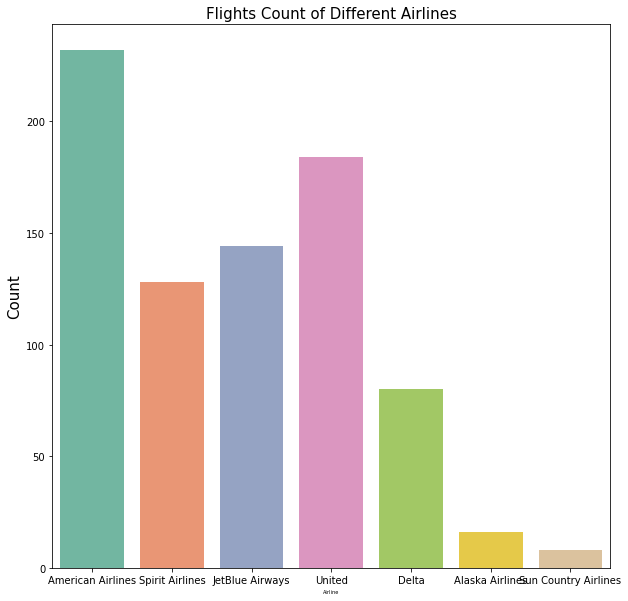

In [51]:
# Visualize number of flights by different airlines 
plt.figure(figsize=(10,10))
sns.countplot(df['airlines'],palette='Set2')
plt.title('Flights Count of Different Airlines',fontsize=15)
plt.xlabel('Airline',fontsize=5)
plt.ylabel('Count',fontsize=15)
plt.show()

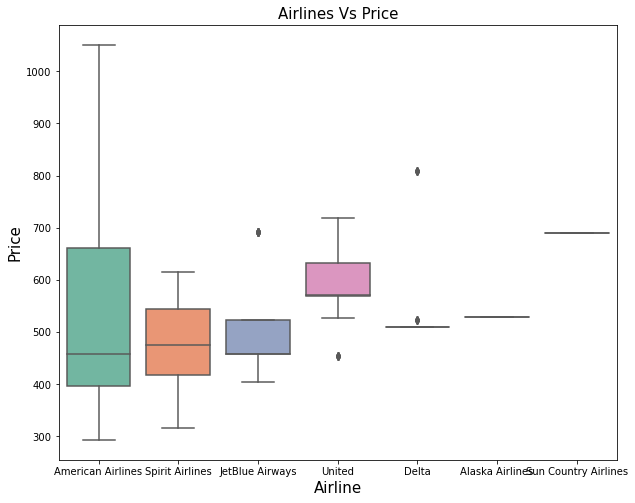

In [52]:
# Airline vs Price
%matplotlib inline
df["prices"] = pd.to_numeric(df["prices"])

plt.figure(figsize=(10,8))
sns.boxplot(x=df['airlines'],y=df['prices'],palette='Set2')
plt.title('Airlines Vs Price',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

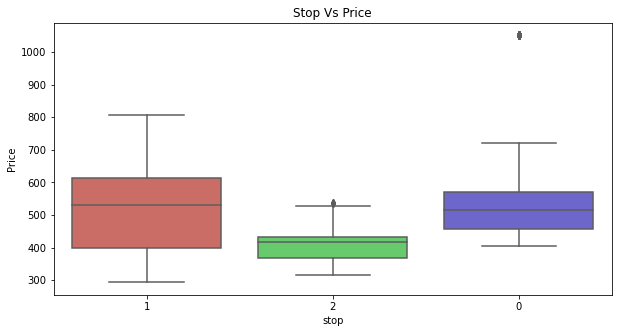

In [53]:
# Stop Vs Price
plt.figure(figsize=(10,5))
sns.boxplot(x='stops',y='prices',data=df,palette='hls')
plt.title('Stop Vs Price',fontsize=12)
plt.xlabel('stop',fontsize=10)
plt.ylabel('Price',fontsize=10)
plt.show()

In [54]:
Morning = ['05:','06:','07:','08:','09:','10:','11:']
for string in Morning: 
    df.dep_times = df.dep_times.apply(lambda x: 'Morning' if string in x else x) 
    df.arr_times = df.arr_times.apply(lambda x: 'Morning' if string in x else x) 

In [55]:
Afternoon = ['12','13','14:','15:','16:']
for string in Afternoon: 
    df.dep_times = df.dep_times.apply(lambda x: 'Afternoon' if string in x else x) 
    df.arr_times = df.arr_times.apply(lambda x: 'Afternoon' if string in x else x)

In [56]:
Evening = ['17:','18','19:','20:','21:']
for string in Evening: 
    df.dep_times = df.dep_times.apply(lambda x: 'Evening' if string in x else x) 
    df.arr_times = df.arr_times.apply(lambda x: 'Evening' if string in x else x)

In [57]:
Night = ['22:','23:','00:','01:','02:','03:','04:']
for string in Night: 
     df.dep_times = df.dep_times.apply(lambda x: 'Night' if string in x else x) 
     df.arr_times = df.arr_times.apply(lambda x: 'Night' if string in x else x)

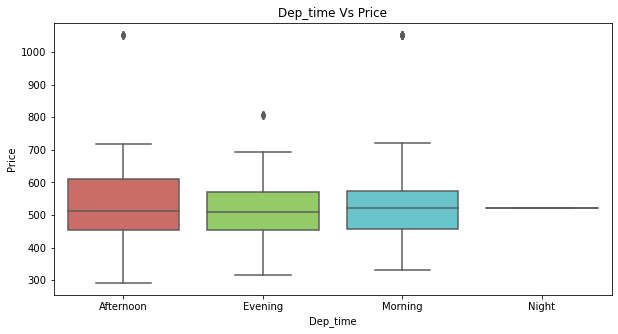

In [58]:
# Dep_times vs Price
plt.figure(figsize=(10,5))
sns.boxplot(x='dep_times',y='prices',data=df,palette='hls')
plt.title('Dep_time Vs Price',fontsize=12)
plt.xlabel('Dep_time',fontsize=10)
plt.ylabel('Price',fontsize=10)
plt.show()

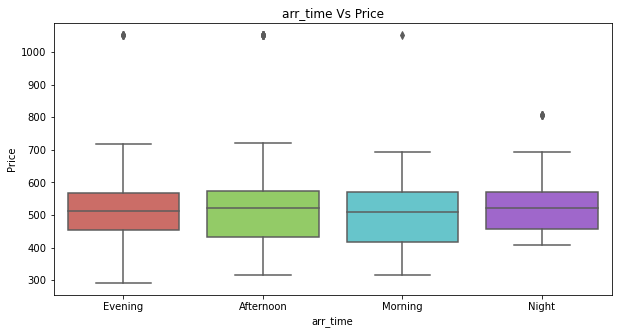

In [59]:
# arr_times vs Price
plt.figure(figsize=(10,5))
sns.boxplot(x='arr_times',y='prices',data=df,palette='hls')
plt.title('arr_time Vs Price',fontsize=12)
plt.xlabel('arr_time',fontsize=10)
plt.ylabel('Price',fontsize=10)
plt.show()

In [60]:
# Categorical Variables 
Cat_var = ['dep_times','arr_times','airlines','crawel_times']

# Numberical Variables
Num_var = ['durations','stops','prices']

In [61]:
# Standardization for Numberical Variables 
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()
df[Num_var] = Scaler.fit_transform(df[Num_var])
df

,dep_times,arr_times,airlines,durations,stops,prices,crawel_times
0,Afternoon,Evening,American Airlines,0.153762,0.5,0.000000,1
1,Evening,Afternoon,Spirit Airlines,1.000000,1.0,0.031662,1
2,Morning,Morning,JetBlue Airways,0.003272,0.0,0.146438,1
3,Morning,Morning,JetBlue Airways,0.015267,0.0,0.153034,1
4,Afternoon,Afternoon,Spirit Airlines,0.014177,0.0,0.325858,1
...,...,...,...,...,...,...,...
787,Morning,Afternoon,American Airlines,0.017448,0.0,0.564644,8
788,Evening,Night,Delta,0.139586,0.5,0.679420,8
789,Morning,Afternoon,American Airlines,0.021810,0.0,1.000000,8
790,Afternoon,Evening,American Airlines,0.030534,0.0,1.000000,8


In [62]:
# Encode Dummy Variables 
df[Cat_var] = df[Cat_var].astype('category')
df[Num_var] = df[Num_var].astype('float64')

df = pd.get_dummies(df, prefix_sep='_', drop_first = True)

In [74]:
# Import package for VIF Check 
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = df
vif['feature'] = X.columns
vif['VIF']     = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF Result
print(vif) 

                          feature       VIF
0                       durations  8.834954
1                           stops  7.308800
2                          prices  4.969533
3               dep_times_Evening  3.977746
4               dep_times_Morning  4.520973
5                 dep_times_Night  1.224223
6               arr_times_Evening  3.277270
7               arr_times_Morning  2.045026
8                 arr_times_Night  3.540145
9      airlines_American Airlines  6.349766
10                 airlines_Delta  2.750996
11       airlines_JetBlue Airways  3.656591
12       airlines_Spirit Airlines  5.440141
13  airlines_Sun Country Airlines  1.283748
14                airlines_United  5.786802
15                 crawel_times_2  1.889134
16                 crawel_times_3  1.891157
17                 crawel_times_4  1.891883
18                 crawel_times_5  1.891902
19                 crawel_times_6  1.979081
20                 crawel_times_7  1.886798
21                 crawel_times_

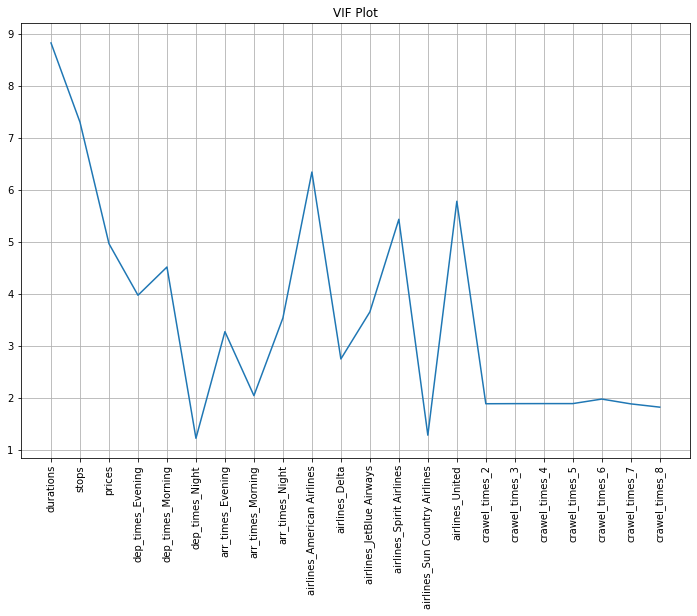

In [80]:
# Visualize VIFs

colnames_vif = vif.feature

plt.figure(figsize=(12,8))
plt.title('VIF Plot',fontsize=12)
plt.plot(range(len(colnames_vif)), vif.VIF.values)
plt.xticks(range(len(colnames_vif)), colnames_vif.values, rotation=90) 

plt.grid()

plt.show()

In [63]:
# Test Train Split

from sklearn.model_selection import train_test_split 
testpart_size = 0.2

DV = 'prices'

X = df.drop(columns = DV)
y = df[DV]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
def summary_coef(model_object):
  n_predictors = X_train.shape[1]
  model_coef = pd.DataFrame(model_object.coef_.reshape(1, n_predictors), columns=X_train.columns.values)
  model_coef['Intercept'] = model_object.intercept_
  return model_coef.transpose()

In [65]:
from sklearn.linear_model import Lasso, LassoCV

# Placeholder variable: kfolds
kfolds = 10

# The optimal Linear Regression model 
# Set n_jobs to be -1 to run LassoCV on all CPU cores.
clf_optimal = LassoCV(cv=kfolds, random_state=1, n_jobs=-1).fit(X_train,y_train)

# Display the optimal alpha that yields the final selected model (the best model candidate)
print(clf_optimal.alpha_)

# Display the estimated coefficients of the final selected model
print(summary_coef(clf_optimal))

# Calcuate the ASE over the test partition based on the final selected model

# Use predict method of the clf_optimal object to apply the model associated with clf_optimal to the test partition
# y_test_predicted is the predicted values of the DV in the test partition 
y_test_predicted = clf_optimal.predict(X_test)

n_obs_test = y.shape[0] 
# Derive ASE over the test partition based on the definition of ASE
ASE_test = sum((y_test - y_test_predicted)**2)/n_obs_test

print(ASE_test)

0.0007149724964170799
                                      0
durations                     -0.000000
stops                         -0.188003
dep_times_Evening             -0.006908
dep_times_Morning              0.014094
dep_times_Night                0.000000
arr_times_Evening              0.001603
arr_times_Morning             -0.017573
arr_times_Night               -0.005910
airlines_American Airlines     0.015726
airlines_Delta                -0.009452
airlines_JetBlue Airways      -0.088180
airlines_Spirit Airlines       0.000000
airlines_Sun Country Airlines  0.183913
airlines_United                0.098095
crawel_times_2                -0.000000
crawel_times_3                 0.011646
crawel_times_4                 0.000000
crawel_times_5                 0.000000
crawel_times_6                -0.000000
crawel_times_7                 0.019752
crawel_times_8                 0.026420
Intercept                      0.355939
0.005807891118944985


In [66]:
# Run Lasso with pre-specified penalty level (alpha) to check the importance of predictors
# Placeholder variable: alpha
alpha = 0.01

clf = Lasso(alpha=alpha, random_state=1).fit(X_train,y_train)

print(summary_coef(clf))

                                      0
durations                     -0.000000
stops                         -0.031297
dep_times_Evening             -0.000000
dep_times_Morning              0.000000
dep_times_Night               -0.000000
arr_times_Evening             -0.000000
arr_times_Morning             -0.000000
arr_times_Night               -0.000000
airlines_American Airlines     0.000000
airlines_Delta                 0.000000
airlines_JetBlue Airways      -0.000000
airlines_Spirit Airlines      -0.000000
airlines_Sun Country Airlines  0.000000
airlines_United                0.049848
crawel_times_2                -0.000000
crawel_times_3                 0.000000
crawel_times_4                -0.000000
crawel_times_5                -0.000000
crawel_times_6                -0.000000
crawel_times_7                 0.000000
crawel_times_8                 0.000000
Intercept                      0.320115


In [67]:
# Pre-defined function for Regression visualization 

def inverse_log1p(Y, inverse=True):
    if inverse==True:
        actual = np.expm1(Y)
    else:
        actual = Y
    return actual

def residual(model,X_train,X_test,y_train,y_test):
    model.fit(X_train, y_train)
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    prediction_train_actual = inverse_log1p(prediction_train)
    prediction_test_actual = inverse_log1p(prediction_test)
    
    # PERFORMANCE METRICS
    mse_test = mean_squared_error(y_test, prediction_test, squared=True)
    rmse_test = mean_squared_error(y_test, prediction_test, squared=False)
    mse_train = mean_squared_error(y_train, prediction_train, squared=True)
    rmse_train = mean_squared_error(y_train, prediction_train, squared=False)
    mse_test_actual = mean_squared_error(inverse_log1p(y_test), inverse_log1p(prediction_test), squared=True)
    rmse_test_actual = mean_squared_error(inverse_log1p(y_test), inverse_log1p(prediction_test), squared=False)
    mse_train_actual = mean_squared_error(inverse_log1p(y_train), inverse_log1p(prediction_train), squared=True)
    rmse_train_actual = mean_squared_error(inverse_log1p(y_train), inverse_log1p(prediction_train), squared=False)
    
    # RESIDUAL FOR ACTUAL AND LOGGED
    residual_train = y_train - prediction_train
    residual_test = y_test - prediction_test
    residual_train_actual = inverse_log1p(y_train) - inverse_log1p(prediction_train)
    residual_test_actual = inverse_log1p(y_test) - inverse_log1p(prediction_test)
    
    fig, axs = plt.subplots(nrows = 2, ncols = 2)
    fig = plt.gcf()
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    fig.set_size_inches(10, 8)
    fig.suptitle(f"Residual of {type(model).__name__}", fontsize=14,fontweight='bold')
    

    axs[0,0].sharex(axs[0,1])
    axs[0,0].sharey(axs[0,1])
    axs[1,0].sharex(axs[1,1])
    axs[1,0].sharey(axs[1,1])
    
    axs[0,0].scatter(x = prediction_train,y = residual_train, alpha=0.1,color='red',label='Train Set')
    axs[0,0].set_title(f'Training Set (Log-Transformed Y)',fontweight='bold')
    axs[0,0].set_xlabel('Predicted Values (Logged)')
    axs[0,0].set_ylabel('Residual')
    yabs_max = abs(max(axs[0,0].get_ylim(), key=abs))
    axs[0,0].axhline(y=0, color='black', linestyle='--', label='Zero Residual')
    axs[0,0].legend()
    
    
    axs[0,1].scatter(x = prediction_test,y = residual_test, alpha=0.1,color='blue',label='Test Set')
    axs[0,1].set_title(f'Testing Set (Log-Transformed Y)',fontweight='bold')
    axs[0,1].set_xlabel('Predicted Values (Logged)')
    yabs_max = abs(max(axs[0,1].get_ylim(), key=abs))
    axs[0,1].axhline(y=0, color='black', linestyle='--', label='Zero Residual')
    axs[0,1].legend()
    
    axs[1,0].scatter(x = prediction_train_actual,y = residual_train_actual, alpha=0.1,color='red',label='Train Set')
    axs[1,0].set_title(f'Training Set (Actual)',fontweight='bold')
    axs[1,0].set_xlabel('Predicted Values (Actual)')
    axs[1,0].set_ylabel('Residual')
    yabs_max = abs(max(axs[1,0].get_ylim(), key=abs))
    axs[1,0].axhline(y=0, color='black', linestyle='--', label='Zero Residual')
    axs[1,0].legend()
    
    axs[1,1].scatter(x = prediction_test_actual,y = residual_test_actual, alpha=0.1,color='blue',label='Train Set')
    axs[1,1].set_title(f'Testing Set  (Actual)',fontweight='bold')
    axs[1,1].set_xlabel('Predicted Values (Actual)')
    yabs_max = abs(max(axs[1,1].get_ylim(), key=abs))
    axs[1,1].axhline(y=0, color='black', linestyle='--', label='Zero Residual')
    axs[1,1].legend()
    
    props = dict(boxstyle='square', facecolor='whitesmoke', alpha=1, pad=0.5)
    axs[0,0].text(0.6, 0.75, f"MSE = {mse_train:.2f} \nRMSE = {rmse_train:.2f}", transform=axs[0,0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    axs[0,1].text(0.6, 0.75, f"MSE = {mse_test:.2f} \nRMSE = {rmse_test:.2f}", transform=axs[0,1].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    axs[1,0].text(0.6, 0.75, f"MSE = {mse_train_actual:.2E} \nRMSE = {rmse_train_actual:.2E}", transform=axs[1,0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    axs[1,1].text(0.6, 0.75, f"MSE = {mse_test_actual:.2E} \nRMSE = {rmse_test_actual:.2E}", transform=axs[1,1].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    return plt.show()

# Calling fit() more than once will overwrite what was learned by any previous fit().
def training_curve(model,X_train,X_test,y_train,y_test, num, parameters = None):
    stages_shape = np.linspace(100, X_train.shape[0], num, dtype =int)
    progress_stages = np.linspace(10, 100, num, dtype =int)/100
    MSE = []
    RMSE = []
    R2 = []
    for stage in stages_shape:
        X_train_temp = X_train[:stage]
        y_train_temp = y_train[:stage]
        model.fit(X_train_temp, y_train_temp)
        prediction_test = model.predict(X_test)
        
        mse = mean_squared_error(y_test, prediction_test, squared=True)
        rmse = mean_squared_error(y_test, prediction_test, squared=False)
        r2 = r2_score(y_test, prediction_test)
        
        MSE.append(mse)
        RMSE.append(rmse)
        R2.append(r2)
        
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex=True)
    fig = plt.gcf()
    fig.subplots_adjust(hspace=0.1)
    fig.set_size_inches(10, 5)
    fig.suptitle(f"{type(model).__name__} Training Curve", fontsize=14,fontweight='bold')
    
    ax1.scatter(x = progress_stages,y = R2, color='deeppink',label='R2',s=10)
    ax1.set_title(f'Metrics of Unseen Data Against Training Data Proportion',fontweight='bold')
    ax1.set_ylabel('R2')
    ax1.legend(loc='center right')
    
    ax2.scatter(x = progress_stages,y = MSE, color='green',label='MSE',s=10, marker=r'x')
    ax2.set_ylabel('MSE')
    ax2.legend(loc='center right')
    
    ax3.scatter(x = progress_stages,y = RMSE, color='olive',label='RMSE',s=10, marker=r'^')
    ax3.set_xlabel('Training Data Proportion',fontweight='bold')
    ax3.xaxis.set_major_formatter(mtick.PercentFormatter())
    ax3.set_ylabel('RMSE')
    ax3.legend(loc='center right')
    fig.text(0.03, 0.5, 'Unseen Testing Set Metrics', va='center', rotation='vertical',fontweight='bold')
    return plt.show()

In [68]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.ticker as mtick

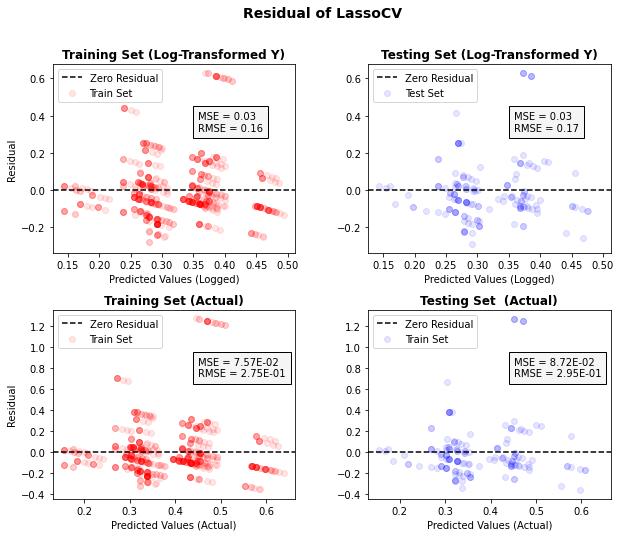

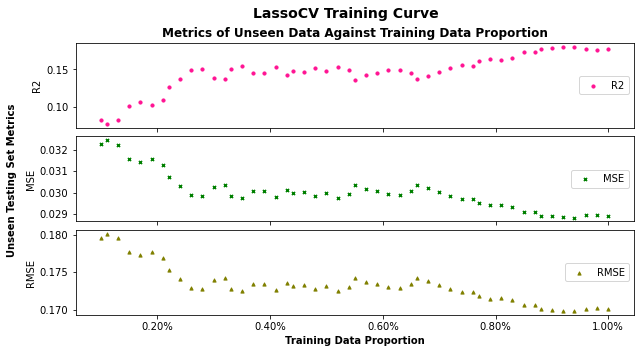

In [69]:
# Based on the residual, we can tell that our data is not autocorrelated 
residual(clf_optimal,X_train,X_test,y_train,y_test)

# Visualize the trainning pattern
training_curve(clf_optimal,X_train,X_test,y_train,y_test, num=50, parameters = None)

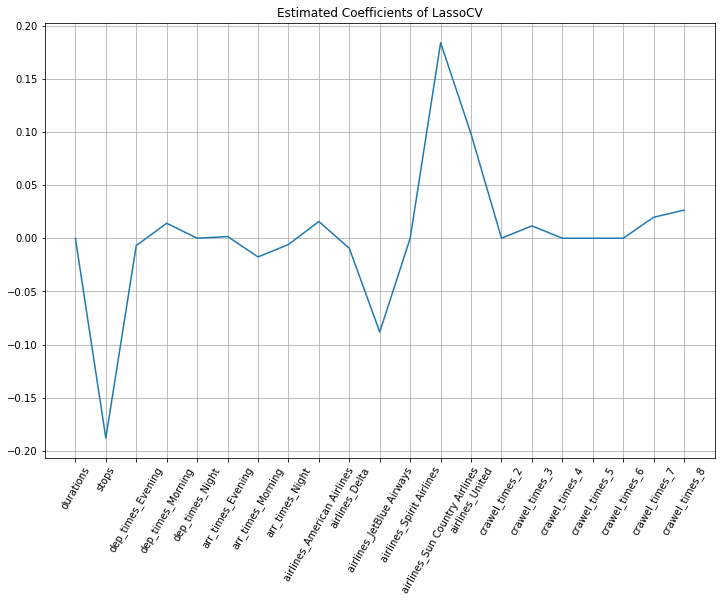

In [71]:
# Visualize the coefficients of LassoCV
lasso_coef = clf_optimal.coef_ 

df_visualize = df.drop(['prices'], axis=1)

colnames = df_visualize.columns

plt.figure(figsize=(12,8))
plt.title('Estimated Coefficients of LassoCV',fontsize=12)
plt.plot(range(len(colnames)), lasso_coef)
plt.xticks(range(len(colnames)), colnames.values, rotation=60) 

plt.grid()

plt.show()